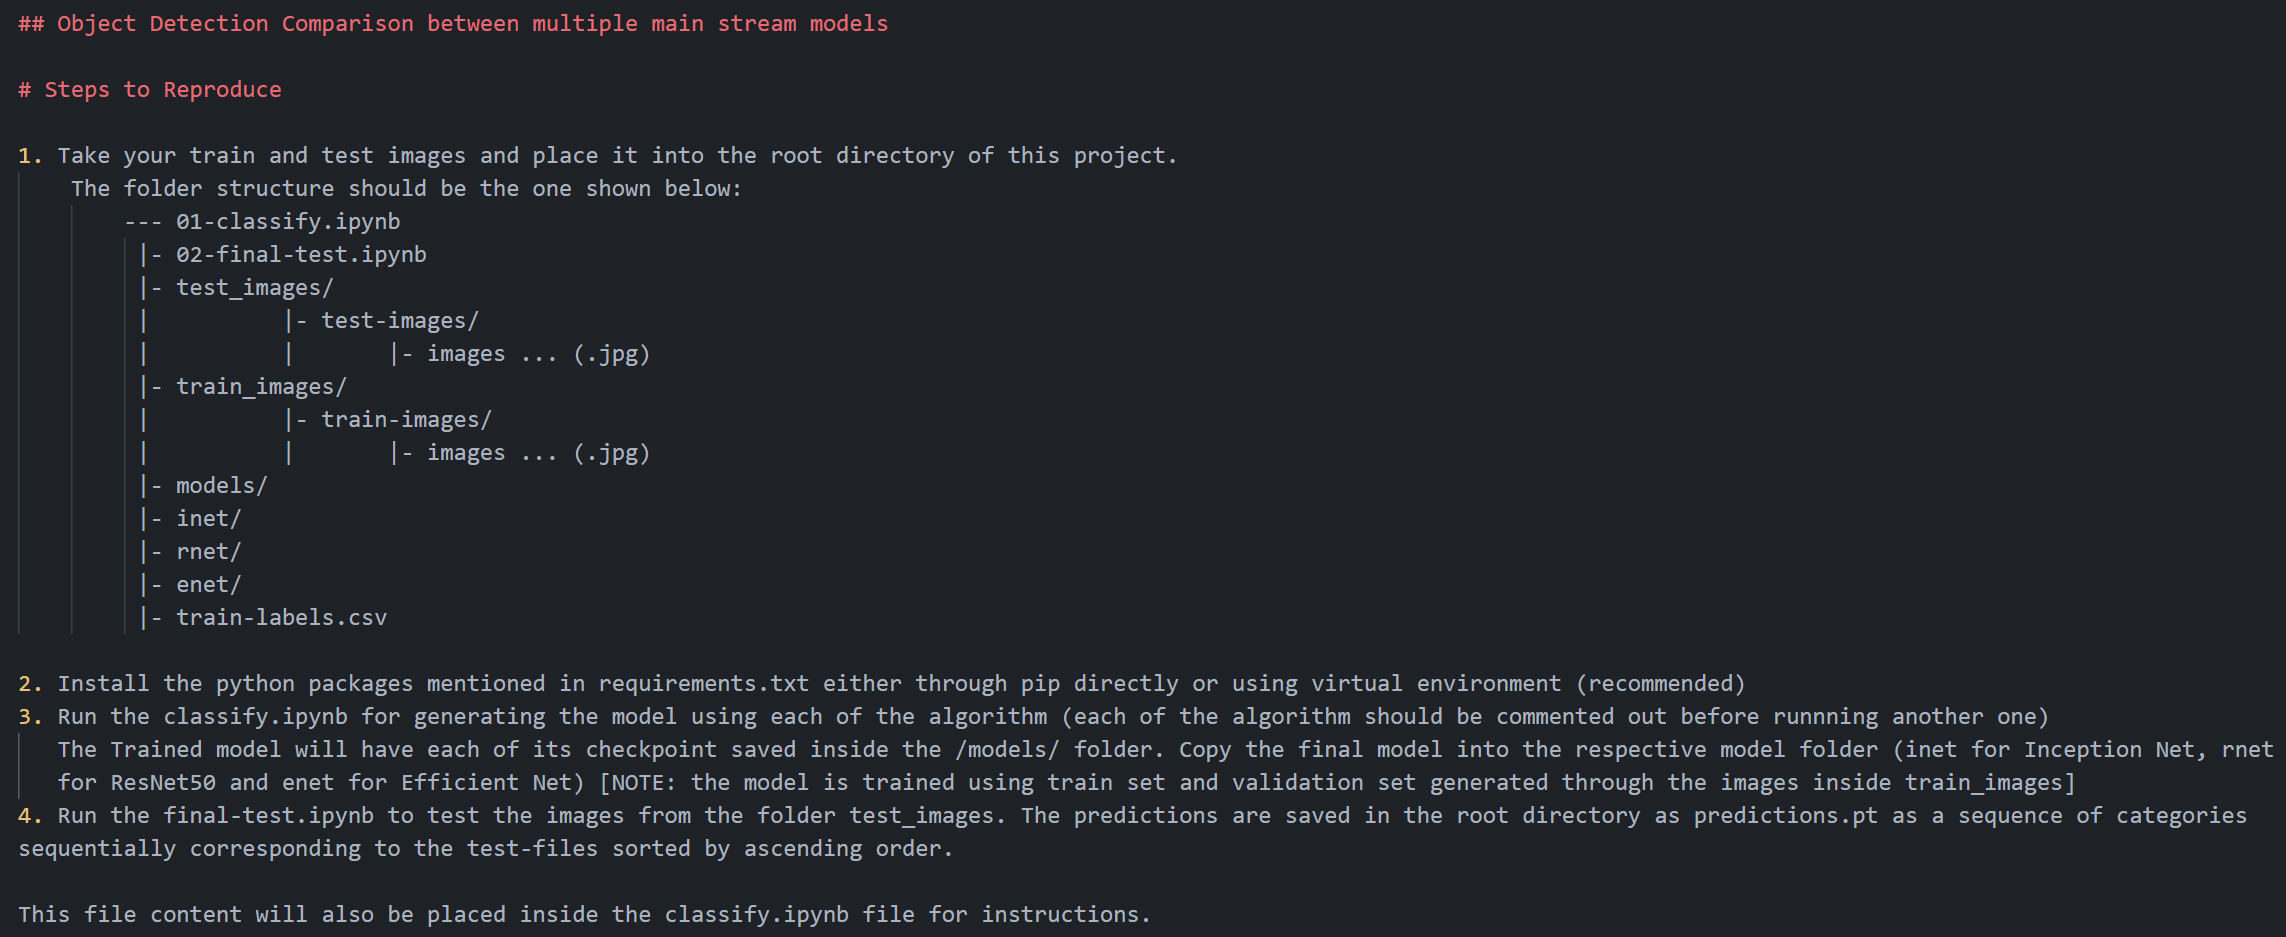

In [ ]:
import os
import numpy as np
import pandas as pd
import wandb

In [ ]:
# labels = pd.read_csv('./train-labels.csv')

In [ ]:
# proper_labels = pd.DataFrame()
# for image in [x for x in os.listdir('./train-files/train_files/') if x.endswith(".jpg")]:
#     file_index = int(image.split(".jpg")[0].split("-")[1])
#     category_index = labels.iloc[file_index]['cat']
#     row = {
#         'filename': image,
#         'file_index': file_index,
#         'category': category_index
#     }
#     proper_labels = pd.concat([proper_labels, pd.DataFrame([row])], ignore_index = True)

In [ ]:
# proper_labels.to_csv('./proper_labels.csv', index = False)

In [ ]:
proper_labels = pd.read_csv('./proper_labels.csv')

In [ ]:
proper_labels

In [ ]:
# getting total number of classes
print(pd.DataFrame(proper_labels[['category', 'filename']].groupby('category').count()).reset_index())
total_categories = len(proper_labels.category.unique())
print("Total categories: ", total_categories)

In [ ]:
import matplotlib.pyplot as plt
import cv2

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import v2 

In [ ]:
import torchvision.models as models

In [ ]:
# efficient net
image_width = 300 
image_height = 200
# inception net
# image_width = 299 
# image_height = 299
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Inferencing and training through: {device}")

In [ ]:
# augmentation and normalization with convertion to tensor
preprocess_image = v2.Compose([
    v2.ToImage(),
    v2.RandomResizedCrop(size=(image_width, image_height), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean, std)
])

In [ ]:
dataset = []
for im_name in [x for x in os.listdir('./train-files/train_files/') if x.endswith(".jpg")]:
    image = cv2.resize(
        cv2.cvtColor(
            cv2.imread(
                f'./train-files/train_files/{im_name}', 
                cv2.IMREAD_COLOR
            ), 
            cv2.COLOR_BGR2RGB
        ), 
        (image_width, image_height)
    ) # read image, convert color space, resize all to (300, 200)
    # preprocessing data images
    image = preprocess_image(image).to(device)
    # embedding the category
    category = torch.tensor(
        [proper_labels[proper_labels['filename'] == im_name].iloc[0]['category']]
    ).to(device)
    dataset.append((image, category))

In [ ]:
class ClassificationDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
final_dataset = ClassificationDataset(dataset)

In [ ]:
train_dataset, validate_dataset = random_split(final_dataset, [0.85, 0.15])

In [ ]:
batch_size = 48

In [ ]:
trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
testloader = DataLoader(validate_dataset, batch_size = batch_size, shuffle = False)

In [ ]:
# efficient net v2_l
model = models.efficientnet_v2_l(weights = 'EfficientNet_V2_L_Weights.DEFAULT')
# model = models.efficientnet_v2_l(weights = None)
# checking the head's name
for name, module in model.named_modules():
    if name.startswith('classifier'):
        print(name, module)
model.classifier = nn.Sequential(
    nn.Dropout(p = 0.5),
    nn.Linear(1280, total_categories, bias = True),
    nn.LogSoftmax(dim=1)
)
# load saved checkpoint
# model.load_state_dict(torch.load('./enet/en3_10.pth'))
# multi gpu optimizations
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model, device_ids = [0, 1])
    final_layer = model.module.classifier
else:
    final_layer = model.classifier
model = model.to(device)

In [ ]:
# # inception net
# model = models.inception_v3(weights = 'Inception_V3_Weights.DEFAULT')
# # checking the head's name
# for name, module in model.named_modules():
#     if name.startswith('fc'):
#         print(name, module)
# model.fc = nn.Sequential(
#     nn.Linear(2048, total_categories, bias = True),
#     nn.LogSoftmax(dim=1)
# )
# if torch.cuda.device_count() > 1:
#     model = nn.DataParallel(model, device_ids = [0, 1])
#     final_layer = model.module.fc
# else:
#     final_layer = model.fc
# model = model.to(device)

In [ ]:
# # resnet50
# model = models.resnet152(weights='ResNet152_Weights.DEFAULT')
# # checking the head's name
# for name, module in model.named_modules():
#     if name.startswith('fc'):
#         print(name, module)
# model.classifier = nn.Sequential(
#     nn.Linear(2048, total_categories, bias = True),
#     nn.LogSoftmax(dim=1)
# )
# # load saved checkpoint
# # model.load_state_dict(torch.load('./enet/en3_10.pth'))
# # multi gpu optimizations
# if torch.cuda.device_count() > 1:
#     model = nn.DataParallel(model, device_ids = [0, 1])
#     final_layer = model.module.fc
# else:
#     final_layer = model.fc
# model = model.to(device)

In [ ]:
# # custom model from scratch
# class Classifier(nn.Module):
#     def __init__(self, in_channels):
#         super(Classifier, self).__init__()
#         self.layer1 = nn.Conv2d(in_channels, 32, 5, 2, 2)
#         self.lrelu = nn.LeakyReLU()
#         self.dropout = nn.Dropout(0.2)
#         self.flatten = nn.Flatten()
#         self.layer2 = nn.Conv2d(32, 64, 3, 1, 2)
#         self.layer3 = nn.Conv2d(64, 128, 3, 1, 2)
#         self.layer4 = nn.Conv2d(128, 1, 4, 2, 2)
#         self.layer5 = nn.Linear(4134, 1000)
#         self.output = nn.Linear(1000, total_categories)

#     def forward(self, x):
#         x = self.lrelu(self.layer1(x))
#         x = self.layer2(x)
#         x = self.dropout(x)
#         x = self.layer3(x)
#         x = self.lrelu(self.layer4(x))
#         x = self.flatten(x)
#         x = self.layer5(x)
#         x = self.output(x)
#         return F.log_softmax(x, dim = 1)
# model = Classifier(3)
# # # multi gpu optimizations
# if torch.cuda.device_count() > 1:
#     model = nn.DataParallel(model, device_ids = [0, 1])
# model = model.to(device)
# print(model)

In [ ]:
def train_model(
        model, model_layer, 
        trainloader, testloader, 
        learning_rate, weights_decay, 
        epochs, train_transferred = False, 
        name = '', run = None
):
    if model_layer is None:
        model_layer = model
    for params in model.parameters():
        params.requires_grad = train_transferred
    for params in model_layer.parameters():
        params.requires_grad = True
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, weight_decay=weights_decay)
    loss_function = nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        for idx, (train_images, train_labels) in enumerate(trainloader):
            optimizer.zero_grad()
            outputs = model(train_images)

            # # for all others
            _, predicted = torch.max(outputs.data, 1)
            loss = loss_function(outputs, train_labels.squeeze())
            # # only for inception net
            # _, predicted = torch.max(outputs[0], 1)
            # loss = loss_function(outputs[0], train_labels.squeeze())

            loss.backward()
            optimizer.step()
            total = train_labels.size(0)
            correct = (predicted == train_labels.squeeze()).sum().item()
            accuracy = (correct*100.0/total)
            if run is not None:
                run.log({
                    'iteration': idx+len(trainloader)*(epoch-1),
                    'train_loss': loss,
                    'train_accuracy': accuracy,
                })
            if idx%50 == 0 or idx == len(trainloader)-1:
                print(f"Epoch {epoch}, iteration: {idx}/{len(trainloader)}, loss: {loss}")
        # validate 
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            loss_list = list()
            for (val_images, val_labels) in testloader:
                outputs = model(val_images)
                
                # # for all others
                _, predicted = torch.max(outputs.data, 1)
                loss_list.append(loss_function(outputs, val_labels.squeeze()).detach().cpu().numpy())
                # # only for inception net
                # _, predicted = torch.max(outputs, 1)
                # loss_list.append(loss_function(outputs, val_labels.squeeze()).detach().cpu().numpy())

                total += val_labels.size(0)
                correct += (predicted == val_labels.squeeze()).sum().item()
        accuracy = (correct*100.0/total)
        if run is not None:
            run.log({
                'epoch': epoch, 
                'val_accuracy': accuracy,
                'val_loss': np.average(loss_list)
            })
        print(f"Validation after Epoch: {epoch}, Accuracy: ", accuracy)
        if name != '':
            torch.save(model.state_dict(), f'./models/{name}_{epoch}.pth')
        else:
            torch.save(model.state_dict(), f'./models/model_{epoch}.pth')

In [ ]:
# # custom
# epochs = 20
# learning_rate = 0.001
# weights_decay = 0.00001
# run = wandb.init(
#     project="assignment-3",
#     name=f"custom-{learning_rate}-head_only",
#     config={
#         "learning_rate": learning_rate,
#         "architecture": "Custom CNN",
#         "dataset": "Custom",
#         "epochs": epochs,
#     }
# )
# run.watch(model, log='all', log_graph=True)
# train_model(
#     model,
#     None,
#     trainloader, 
#     testloader, 
#     learning_rate, 
#     weights_decay,
#     epochs, 
#     train_transferred = False, 
#     run = run, 
#     name="pt_no"
# )
# run.finish()
# # retraining the entire model with lower learning rate
# epochs = 20
# learning_rate = 0.0001
# run = wandb.init(
#     project="assignment-3",
#     name=f"custom-{learning_rate}-all",
#     config={
#         "learning_rate": learning_rate,
#         "architecture": "Custom CNN",
#         "dataset": "Custom",
#         "epochs": epochs,
#     }
# )
# train_model(
#     model,
#     None,
#     trainloader, 
#     testloader, 
#     learning_rate, 
#     weights_decay,
#     epochs, 
#     train_transferred = True, 
#     run = run, 
#     name="pt_yes"
# )
# run.finish()

In [ ]:
# efficientnet_v2_l
epochs = 25
learning_rate = 0.001
weights_decay = 0.00001
run = wandb.init(
    project="assignment-3",
    name=f"enet-b{batch_size}-{learning_rate}-head_only",
    config={
        "learning_rate": learning_rate,
        "architecture": "Efficient Net V2_L",
        "dataset": "Custom",
        "epochs": epochs,
    }
)
run.watch(model, log='all', log_graph=True)
train_model(
    model,
    final_layer,
    trainloader, 
    testloader, 
    learning_rate,
    weights_decay,
    epochs, 
    train_transferred = False, 
    run = run, 
    name="pt_no_2"
)
run.finish()
# retraining the entire model with lower learning rate
epochs = 10
learning_rate = 0.0001
run = wandb.init(
    project="assignment-3",
    name=f"enet-b{batch_size}-{learning_rate}-all",
    config={
        "learning_rate": learning_rate,
        "architecture": "Efficient Net V2_L",
        "dataset": "Custom",
        "epochs": epochs,
    }
)
train_model(
    model,
    final_layer,
    trainloader, 
    testloader, 
    learning_rate,
    weights_decay,
    epochs, 
    train_transferred = True, 
    run = run, 
    name="pt_yes_2"
)
run.finish()

In [ ]:
# # inception_netv3
# epochs = 20
# learning_rate = 0.001
# weights_decay = 0.00001
# run = wandb.init(
#     project="assignment-3",
#     name=f"inet-{learning_rate}-head_only",
#     config={
#         "learning_rate": learning_rate,
#         "architecture": "Inception Net V3",
#         "dataset": "Custom",
#         "epochs": epochs,
#     }
# )
# run.watch(model, log='all', log_graph=True)
# train_model(
#     model,
#     final_layer,
#     trainloader, 
#     testloader, 
#     learning_rate, 
#     weights_decay,
#     epochs, 
#     train_transferred = False, 
#     run = run, 
#     name="pt_no"
# )
# run.finish()
# # retraining the entire model with lower learning rate
# epochs = 20
# learning_rate = 0.0001
# run = wandb.init(
#     project="assignment-3",
#     name=f"inet-{learning_rate}-all",
#     config={
#         "learning_rate": learning_rate,
#         "architecture": "Inception Net V3",
#         "dataset": "Custom",
#         "epochs": epochs,
#     }
# )
# train_model(
#     model,
#     final_layer,
#     trainloader, 
#     testloader, 
#     learning_rate, 
#     weights_decay,
#     epochs, 
#     train_transferred = True, 
#     run = run, 
#     name="pt_yes"
# )
# run.finish()

In [ ]:
# # RESNET152
# epochs = 20
# learning_rate = 0.001
# weights_decay = 0.00001
# run = wandb.init(
#     project="assignment-3",
#     name=f"resnet-{learning_rate}-head_only",
#     config={
#         "learning_rate": learning_rate,
#         "architecture": "ResNet152",
#         "dataset": "Custom",
#         "epochs": epochs,
#     }
# )
# run.watch(model, log='all', log_graph=True)
# train_model(
#     model,
#     final_layer,
#     trainloader, 
#     testloader, 
#     learning_rate,
#     weights_decay,
#     epochs, 
#     train_transferred = False, 
#     run = run, 
#     name="pt_no"
# )
# run.finish()
# # retraining the entire model with lower learning rate
# epochs = 20
# learning_rate = 0.0001
# run = wandb.init(
#     project="assignment-3",
#     name=f"resnet-{learning_rate}-all",
#     config={
#         "learning_rate": learning_rate,
#         "architecture": "ResNet152",
#         "dataset": "Custom",
#         "epochs": epochs,
#     }
# )
# train_model(
#     model,
#     final_layer,
#     trainloader, 
#     testloader, 
#     learning_rate,
#     weights_decay,
#     epochs, 
#     train_transferred = True, 
#     run = run, 
#     name="pt_yes"
# )
# run.finish()

In [ ]:
# # if multi gpu is being used convert parallel model to single model
# model.load_state_dict(torch.load('./models/enet3_10_parallel.pth'))
# torch.save(model.module.state_dict(), './models/en3_10.pth')

In [ ]:
# finaltestloader = DataLoader(test_image_tensor, batch_size = 1, shuffle = False)
# model.eval()
# predicted = None
# with torch.no_grad():
#     for idx, test_images in enumerate(finaltestloader):
#         outputs = model(test_images)
#         _, predicted = torch.max(outputs.data, 1)
    
# torch.save(predicted, './predictions.pt')    